# What is ```torch.nn``` really?
- 파이토치는 상용자가 인공신경망을 직접 만들고 학습하는 것을 돕는 **```torch.nn, torch.optim, Dataset, DataLoader```** 모듈과 클래스를 제공함
- 이 모듈을 자신의 문제에 제대로 사용하려면 이들의 동작 원리를 이해해야 함
- 그 이해를 돕기 위해 **MNIST 데이터셋에 대해 기본적인 인공신경망을 학습해보겠음**
- 처음엔 아무런 기능을 쓰지 않고 구현한 다음. **점차 위 모듈을 이용하면서 얼마나 쉽고 편해지는지 볼 것**

---
# 1. MNIST data setup
- **classic MNIST 데이터셋**을 사용할 것
- 0~9 클래스의 손글씨 데이터가 흑백 이미지로 구성되어 있음
- 여기선 **pathlib** 라이브러리를 이용하여 path 를 다루고 **request** 라이브러리를 이용하여 데이터셋을 다운받을 것

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnsit"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

- numpy array 형식의 데이터셋이 pickle 을 이용해 저장됨.

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

- 각 이미지는 28x28 크기로 flatten 된 형태인 784 길이의 벡터로 저장되어 있음
- 이를 reshape 하여 한 번 시각화하겠음

(50000, 784)


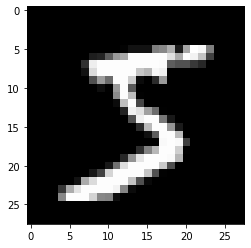

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

- 파이토치는 numpy 의 array 보다는 ```torch.tensor``` 형식의 데이터를 사용함
- 이에 맞게 데이터를 변환하겠음

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


---
# 2. Neural net from sctach (no torch.nn)
- 우선 **Pytorch 의 tensor 연산을 이용하지 않고 인공신경망을 구현해 볼 것**
- 파이토치는 간단한 linear 모델에 필요한 weight 나 bias 를 생성하기 위해 필요한 random 또는 0으로 채워진 텐서를 생성하는 메서드를 제공함.
- 생성한 텐서의 ```requires_grad=True``` 로 설정하면 해당 텐서가 이용된 모든 연산을 추적하여 역전파하여 gradient 를 자동으로 계산할 수 있음

In [14]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)    # Xavier initialization (dividing with 1/sqrt(n))
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

- gradient 를 자동으로 계산할 수 있으므로 statndard Python function 을 이용하여 모델로 사용할 수 있음
- 여기선 평범한 행렬곱과 broadcasted addition 을 작성하여 간단한 선형 모델을 만들어볼 것
- **활성 함수** 도 필요한데 *log_softmax* 함수를 구현하여 사용할 것

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

- @ 는 dot product 를 의미
- 데이터의 batch 에 대해서 위 함수를 호출할 수 있음
- 이는 *한 번의 forward pass* 임

In [15]:
batch_size = 64

xb = x_train[0: batch_size]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.5887, -2.3234, -2.1606, -2.3063, -2.3442, -2.2755, -2.0596, -2.4067,
        -2.7051, -2.0487], grad_fn=<SelectBackward>) torch.Size([64, 10])


- 이제 **negative log-likelihood** 를 loss function 으로 구현해 보겠음

In [16]:
def nll(y, target):
    return -y[range(target.shape[0]), target].mean()

loss_func = nll

In [17]:
yb  = y_train[0: batch_size]
print(loss_func(preds, yb))

tensor(2.4103, grad_fn=<NegBackward>)


- 모델의 성능을 평가하는 함수도 작성해 보겠음
- 여기선 **정확도** 성능으로 사용. preds 중에 가장 큰 값을 갖는 index 가 target 값과 맞다면 옳은 출력이라고 판단

In [18]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [19]:
print(accuracy(preds, yb))

tensor(0.0938)


- 이제 training loop 를 짜볼 것
>**For each iteration**
>1. 데이터셋으로부터 batch_size 만큼 미니배치 추출
>2. model 로 prediction 을 생성
>3. prediction 과 label 을 비교하여 loss 를 계산
>4. ```loss.backward()``` 를 이용하여 모델의 각 파라미터의 gradient를 구함

- 이 gradient 를 이용해 파라미터를 업데이트
- 파라미터를 업데이트하는 부분은 ```torch.no_grad``` 블록 안에서 진행함. 이유는 파마리터를 업데이트하는 연산이 다음 gradient 계산에 영향을 미치는 것을 방지하기 위함
- 업데이트 후엔 해당 파라미터에 저장된 gradient 를 0으로 초기화함

In [21]:
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1) // batch_size+1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [22]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0819, grad_fn=<NegBackward>) tensor(1.)


---
# 3. Using ```torch.nn.functional```
- 파이토치의 ```nn``` 클래스를 이용하여 위 코드를 다시 작성하겠음
- ```nn``` 의 기능을 사용할 때마다 **코드는 짧아지고, 이해하기 쉬워지며, 더 유연해질 것임**

- 첫 째로 수기로 작성된 활성 함수와 loss function 을 ```torch.nn.functional``` 을 이용하여 코드를 짧게 만들 수 있음
- 해당 모듈은 다양한 loss 와 활성 함수는 물론 인공신경망을 작성하기 편하게 해주는 다양한 함수도 있음

In [23]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

- 위에서 사용한 **log likelihood loss** 와 **softmax 활성함수** 를 하나로 합친 ```F.cross_entropy``` 로 대체
- 이제 더이상 모델 안에서 활성 함수를 적지 않아도 됨

In [24]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0819, grad_fn=<NllLossBackward>) tensor(1.)


---
# 4. Refactor using ```nn.Module```
- ```nn.Module, nn.Parameter``` 를 이용하여 training loop 를 좀 더 명확하고 간결하게 만들어 보겠음
- 우리는 weight, bias 와 forward step 을 위한 메서드를 갖는 클래스를 생성하고 싶음
- 이를 ```nn.Module``` 클래스를 상속하여 구현할 수 있음

In [25]:
from torch import nn

class MNIST_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [26]:
model = MNIST_Logistic()

In [27]:
print(loss_func(model(xb), yb))

tensor(2.3626, grad_fn=<NllLossBackward>)


- 앞서 작성했던 training loop 부분에서 각 파라미터를 업데이트하는 부분도 간결해짐

In [30]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // batch_size+1):
            start_i = i*batch_size
            end_i = start_i + batch_size
            xb = x_train[start_i: end_i]
            yb = y_train[start_i: end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
fit()

In [31]:
print(loss_func(model(xb), yb))

tensor(0.0803, grad_fn=<NllLossBackward>)


---
# 5. Refactor using ```nn.Linear```
- weight , bias 나 ```xb @ self.weights + self.bias``` 를 직접 정의하지 않고 **nn.Linear** 클래스를 선형 레이어로 생성하여 코드를 간결하게 할 수 있음

In [32]:
class MNIST_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [33]:
model = MNIST_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3032, grad_fn=<NllLossBackward>)


In [34]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0806, grad_fn=<NllLossBackward>)


---
# 6. Refactor using ```optim```
- ```torch.optim``` 은 다양한 최적화 알고리즘을 제공함
- optimizer 의 ```step``` 메서드를 이용하면 파라미터의 업데이트가 훨씬 간편해짐

In [37]:
from torch import optim

def get_model():
    model = MNIST_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n-1) // batch_size+1):
        start_i = i*batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
            
print(loss_func(model(xb), yb))

tensor(2.3143, grad_fn=<NllLossBackward>)
tensor(0.0812, grad_fn=<NllLossBackward>)


---
# 7. Refactor using Dataset
- ```len, getitem``` 메서드가 있는 모든 클래스를 파이토치의 **Dataset** 으로 사용할 수 있음
- 파이토치의 **TensorDataset** 은 텐서를 감싼 Dateset 임
- 데이터셋의 인덱스를 이용하여 데이터에 접근하는 방법을 쉽게 해줌

In [39]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

In [40]:
model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n-1) // batch_size+1):
        start_i = i*batch_size
        end_i = start_i + batch_size
        xb, yb = train_ds[start_i: end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
            
print(loss_func(model(xb), yb))

tensor(2.3573, grad_fn=<NllLossBackward>)
tensor(0.0815, grad_fn=<NllLossBackward>)


---
# 8. Refactor using DataLoader
- ```DataLoader``` 는 어떤 ```Dataset``` 으로부터도 만들 수 있음
- ```DataLoader``` 는 데이터셋을 배치로 iterate 하는 것을 도와줌
- ```train_ds[start_i: end_i]``` 로 미니 배치를 갖고 오지 않고 DataLoader 를 통해 자동으로 갖고 올 수 있음

In [42]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl =  DataLoader(train_ds, batch_size=batch_size)

In [44]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
print(loss_func(model(xb), yb))

tensor(0.0827, grad_fn=<NllLossBackward>)


---
# 9. Add validation
- 이제 validation set을 이용하여 성능을 평가하는 **Validation** 을 구현해야 함
- 학습 데이터셋의 경우 과적합을 방지하기 위해 **데이터를 셔플하는 것이 중요했지만**
- 검증 데이터셋의 경우 그렇지 않음. 셔플링은 시간만 더 소요될 뿐

- 여기선 검증셋에 대한 batch_size 를 2배 키움
- 검증셋에 대해선 역전파할 필요가 없기 때문에(gradient 저장도 마찬가지) 배치 크기를 늘려도 됨

In [45]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size*2)

In [46]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        
    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3243)
1 tensor(0.2908)


---
# 10. Create fit() and get_data()
- 학습 loss 를 구할 때와 검증 loss 를 구할 때 같은 과정이 두 번 반복되므로 이를 함수화 하겠음
- ```loss_batch``` 는 배치 데이터에 대해 loss를 계산해 줌

In [47]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

- ```fit()``` 은 학습에 필요한 연산을 진행하고 각 에폭마다 검증셋에 대한 검증을 진행함

In [59]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(epoch, val_loss)

- ```get_data()``` 는 학습셋과 검증셋에 해단 dataloader 를 반환

In [57]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*2),
    )

- 위 함수들을 이용해 더욱 간단하게 모델의 학습 및 검증을 구현

In [60]:
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3238442316889763
1 0.30318270224928856


---
# 11. Switch to CNN
- 간단한 선형 모델을 3개의 합성곱 층으로 이루어진 CNN 으로 만들어 보겠음
- CNN으로 바꿔도 위에서 만든 함수들은 어떤 변형도 없이 그대로 사용 가능
- 각 합성곱 층 뒤엔 ReLU 활성 함수를 붙임
- 마지막엔 average pooling 사용 
- torch의 ```view()``` 는 numpy의 ```reshape()``` 와 같음

In [62]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))
    
lr = 0.1

- **momentum** 은 SGD 의 변종으로 대체로 학습 속도를 빠르게 해줌

In [63]:
model = MNIST_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.31749366780519483
1 0.23824304354190826


---
# 12. ```nn.Sequential```
- ```torch.nn``` 는 **Sequential** 이라는 간편만 수기 모델 작성 클래스도 제공함
- ```Sequential``` 객체는 담겨있는 각 모듈을 순차적으로 동작함
- ```Sequential``` 객체를 잘 활용하려면 **사용자 정의 layer** 를 정의하여 넣으면 됨
- 예를 들어 파이토치는 **view()** 역할을 하는 레이러를 따로 제공하지 않으므로 ```Lambda``` 층을 새로 만들어서 기능을 구현할 수 있음

In [65]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

- 이제 ```Sequential``` 로 모델을 간단히 만들 수 있음

In [67]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=2),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=2),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=2),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.365802799320221
1 0.25171426503658295


---
# 13. Wrapping DataLoader
- 지금 만든 CNN 은 간단하지만 MNIST 데이터셋에서만 동작함
- 왜냐하면 입력을 28x28 길이의 벡터만 받고 마지막 CNN 의 해상도가 4x4 로 정해져 있기 때문

- 위 가정을 제거하여 **모델을 더 일반적으로 사용할 수 있게 해보겠음**
1. 먼저 처음 Lambda 층을 제거하고 그 역할을 데이터 전처리 부분에서 대신할 수 있음

In [68]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield(self.func(*b))
            
train_dl, vlaid_dl = get_data(train_ds, valid_ds, batch_size)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

2. 다음으로 ```nn.AvgPool2d``` 를 ```nn.AdaptiveAvgPool2d``` 로 대체할 수 있음
- 이는 입력 텐서의 사이즈가 정의되어 있지 않아 입력으로 어떤 사이즈의 데이터를 받을 수 있음

In [81]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [83]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4577183678150177
1 0.28313275858163833


---
# 14. Using your GPU
- GPU 를 사용한다면 학습을 훨씬 더 빠르게 마칠 수 있음

In [84]:
print(torch.cuda.is_available())

True


In [85]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

- ```preprocess``` 함수를 수정하여 각 배치를 gpu 상으로 옮김

In [86]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(device), y.to(device)

train_dl, vlaid_dl = get_data(train_ds, valid_ds, batch_size)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

- 마지막으로 모델도 gpu 상으로 옮김

In [87]:
model.to(device)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

- 이제 학습 속도가 훨씬 빨라짐을 확인할 수 있음

In [88]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.2680617673873901
1 0.20872771389484404
